In [1]:
import os
import shutil#
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import time
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline

%load_ext autoreload

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%autoreload

read 4 files
0 files couldn't be read by pd, 0 were too short, 4 worked
generating 20 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 84
created union_x attribute of length 362
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (84, 310, 3), instead of a list of numpy arrays


/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/3651826466.py:7: RankWarning: Polyfit may be poorly conditioned
  Edelson = DataSet() \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/3651826466.py:7: RankWarning: Polyfit may be poorly conditioned
  Edelson = DataSet() \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/3651826466.py:7: RankWarning: Polyfit may be poorly conditioned
  Edelson = DataSet() \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/3651826466.py:7: RankWarning: Polyfit may be poorly conditioned
  Edelson = DataSet() \
/Users/mattlowery/Desktop/code/astro/hetvae/src/dataset.py:209: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


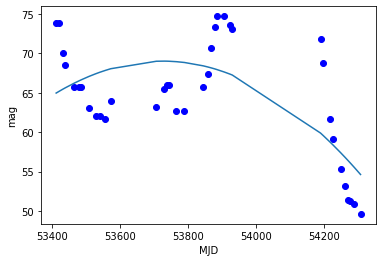

In [3]:

#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('../data/KOSHIDA/*')

# hypers: 
Edelson = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy(minimum=25) \
            .handle_dups() \
            .prune_graham(plot=True, index=2) \
            .resample_dataset(num_samples=20) \
            .normalize() \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight()

# hypers: 

# Edelson.union_x.shape

In [4]:
print(torch.Tensor(Edelson.union_x).shape)

torch.Size([362])


In [5]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Catalina data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('../data/CAT/*/*')[:10]


Catalina = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy() \
            .handle_dups() \
            .prune_graham(plot=True, index=10, std_threshold=1) \
            .resample_dataset(num_samples=20) \
            .normalize() \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight()


Catalina.dataset= Catalina.dataset[18:19, :, :]
print(Catalina.dataset.shape)
# hypers: 


# plt.scatter(Catalina.dataset[1,:-100,0], Catalina.dataset[1,:-100,1])
# Catalina.union_x.shape

read 10 files
0 files couldn't be read by pd, 0 were too short, 10 worked
generating 20 new sample of each example in the dataset & appending them 
 old dataset length: 10
new dataset length: 210
created union_x attribute of length 6322
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (210, 644, 3), instead of a list of numpy arrays
(1, 644, 3)


/Users/mattlowery/Desktop/code/astro/hetvae/src/dataset.py:209: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


g
i
r
u
z
generating 20 new sample of each example in the dataset & appending them 
 old dataset length: 5
new dataset length: 105
created union_x attribute of length 2438
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (105, 619, 3), instead of a list of numpy arrays


/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/1360854858.py:18: RankWarning: Polyfit may be poorly conditioned
  AGN_1H2106 = AGN_1H2106.handle_dups() \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/1360854858.py:18: RankWarning: Polyfit may be poorly conditioned
  AGN_1H2106 = AGN_1H2106.handle_dups() \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/1360854858.py:18: RankWarning: Polyfit may be poorly conditioned
  AGN_1H2106 = AGN_1H2106.handle_dups() \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/1360854858.py:18: RankWarning: Polyfit may be poorly conditioned
  AGN_1H2106 = AGN_1H2106.handle_dups() \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_40458/1360854858.py:18: RankWarning: Polyfit may be poorly conditioned
  AGN_1H2106 = AGN_1H2106.handle_dups() \
/Users/mattlowery/Desktop/code/astro/hetvae/src/dataset.py:209: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:

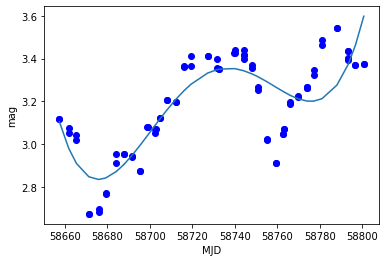

In [6]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#------------------------------

agn_df = pd.read_csv('../data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv')
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)
    print(lc_df[0])
# lcs[0] = lcs[0][lcs[0][:,0].argsort()]
# lcs[0] = np.concatenate((lcs[0][:10], lcs[0][410:]))

# lcs = [lcs[0], lcs[0]]
AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part
AGN_1H2106 = AGN_1H2106.handle_dups() \
                      .prune_graham(plot=True, index=3) \
                      .resample_dataset(num_samples=20) \
                      .normalize() \
                      .reorder() \
                      .set_union_x() \
                      .zero_fill() \
                      .error_to_sample_weight() \
                      .set_target_x()


#AGN_1H2106.dataset = AGN_1H2106.dataset[0:1, :,:]



In [7]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.19462264721791603, 
                 elbo_weight=4.108914123847402, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=32, lr=0.001, mixing='concat_and_mix', mse_weight=4.060280688730988, net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, 
                 sample_tp=0.4733820088130086, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps')



In [8]:
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('mps' if torch.has_mps else 'cpu')

In [9]:
LightCurves = AGN_1H2106.dataset
print(LightCurves.shape)


(105, 619, 3)


In [10]:
training, valid = np.split(LightCurves, [int(np.floor(1*len(LightCurves)))])# shuffle?

train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
       

In [33]:
net = models.load_network(args, DIM, torch.Tensor(AGN_1H2106.union_x))
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.003572758547163779)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=150)

In [34]:
for g in optimizer.param_groups:
    g['lr'] = 0.001463275753032352

In [35]:
AGN_1H2106.set_target_x(100)
recons = []
end_times = []
nlls = []
mses = []
epochs = []

lrs = []

In [36]:
AGN_1H2106.dataset.shape

(105, 619, 3)

In [30]:
%autoreload

In [39]:
start = time.time()
for epoch in range(1, 11): #args.niters + 1):
    nll, mse, _,_,_ = my_utils.train(net, optimizer, epoch, train_loader, args, errors=False, device='mps')
    print(epoch)
    scheduler.step() 
    lrs.append(optimizer.param_groups[0]["lr"])
    if epoch % 10 == 0 or epoch == 1:
        epochs.append(epoch)
        nlls.append(nll)
        mses.append(mse)
        end = time.time()
        end_times.append(end)
        #reconstruction, qz_mean, qz_std,ex = viz_per_example(Edelson.dataset[0], Edelson.target_x[0], net, num_points=100, device=device, k_iwae=50)
        reconstruction, qz_mean, qz_std,ex = viz_per_example(AGN_1H2106.dataset[0], AGN_1H2106.target_x[0] , net, num_points=100, device=device, k_iwae=50)
        
        #recons.append(reconstruction)

1
2
3
4
5
6
7
8
9
10


In [13]:
os.listdir()

['mlp_lags.py',
 'train.py',
 'layers.py',
 'vae_models.py',
 'dataset.py',
 'lcs.py',
 'utils.py',
 'my_utils.py',
 'light_curve_demo.ipynb',
 'p_attn',
 'optuna.ipynb',
 'models.py',
 'synthetic_data_interpolation.ipynb',
 'catalina_training.ipynb',
 'mcmc.py',
 'catalina_optuna.ipynb',
 '__pycache__']

Text(0.5, 1.0, 'NGC 4593, K Band')

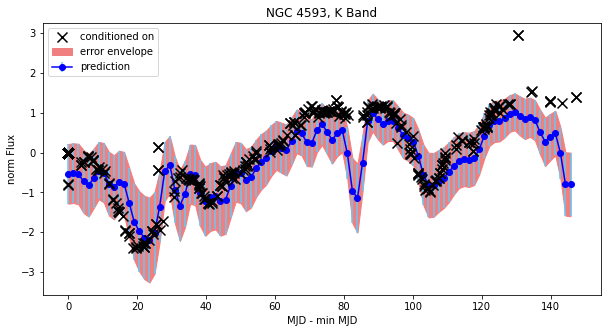

In [40]:
# checking reconstruction
x = ex[0,:,0]
y = ex[0,:,1]
sub = ex[0,:,3]
rec = ex[0,:,4]
xsub = x*sub
xrec = x*rec
ysub = y*sub
yrec = y*rec
plt.figure(figsize=(10,5))
plt.scatter(xsub,ysub, c='black', marker='x', zorder=30, label='conditioned on', s=100)
plt.errorbar(reconstruction[:,0], reconstruction[:,1], yerr=reconstruction[:,2], c='blue', ecolor='#65c9f7', marker='o', label='prediction')
plt.fill_between(reconstruction[:,0], reconstruction[:,1]-reconstruction[:,2],reconstruction[:,1]+reconstruction[:,2],label='error envelope',color='lightcoral')
plt.legend(loc="upper left")
plt.xlabel('MJD - min MJD')
plt.ylabel('norm Flux')
plt.title('NGC 4593, K Band')
#plt.errorbar(reconstruction[:,0], reconstruction[:,1], yerr=reconstruction[:,2])

In [12]:
AGN_1H2106.error_to_sample_weight()
AGN_1H2106.dataset[0,:10,2]

array([0.09576505, 0.09576505, 0.07400027, 0.08705914, 0.07835323,
       0.06964731, 0.07400027, 0.07400027, 0.07400027, 0.06964731],
      dtype=float32)

In [13]:
elapsed = [f'{round((end - start),3)}' for end in end_times]
mses = [round(float(mse), 3) for mse in mses]
nlls = [round(float(nll), 3) for nll in nlls]
elapsed.insert(0,'0')
print(elapsed, mses, nlls)

['0', '0.194', '0.333', '0.48', '0.635', '0.786', '0.94', '1.103', '1.249', '1.391', '1.537', '1.686', '1.832', '1.986', '2.135', '2.282', '2.431', '2.582', '2.729', '2.877', '3.025', '3.187', '3.334', '3.483', '3.626', '3.772', '3.919', '4.066', '4.222', '4.363', '4.508', '4.649', '4.792', '4.941', '5.091', '5.246', '5.395', '5.541', '5.686', '5.831', '5.976', '6.123', '6.274', '6.425', '6.578', '6.729', '6.885', '7.033', '7.187', '7.332', '7.479', '7.626', '7.778', '7.925', '8.075', '8.231', '8.381', '8.527', '8.676', '8.823', '8.975', '9.126', '9.283', '9.43', '9.575', '9.723', '9.874', '10.019', '10.171', '10.322', '10.467', '10.613', '10.762', '10.91', '11.057', '11.206', '11.36', '11.506', '11.653', '11.798', '11.948', '12.101', '12.25', '12.401', '12.55', '12.705', '12.858', '13.003', '13.153', '13.303', '13.448', '13.595', '13.742', '13.889', '14.036', '14.183', '14.345', '14.489', '14.634', '14.78', '14.926', '15.076'] [10.331, 9.996, 9.439, 9.497, 9.43, 9.429, 9.458, 9.462, 9

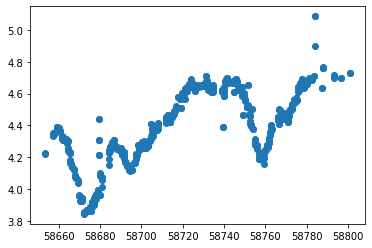

In [14]:
# denormalize reconstructions and the example we're going to animate

i = 0
xmin = AGN_1H2106.x_min[0]
ymean, ystd = AGN_1H2106.y_mean_std[0]

denorm_recons = []

for recon in recons:
    denorm_recon = recon.copy()
    denorm_recon[:,0] = (denorm_recon[:,0]) + xmin
    denorm_recon[:,1] = (denorm_recon[:,1] * ystd) + ymean
    denorm_recon[:,2] = denorm_recon[:,2] * ystd
    denorm_recons.append(denorm_recon)


ex= AGN_1H2106.dataset[i].copy()
ex[:,0] = (ex[:,0]) + xmin
ex[:,1] = (ex[:,1]) * ystd + ymean
ex[:,2] = ex[:,2] * ystd

plt.scatter(ex[:,0], ex[:,1])
# plt.plot(recons[0][:,0], recons[0][:,1])

In [15]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

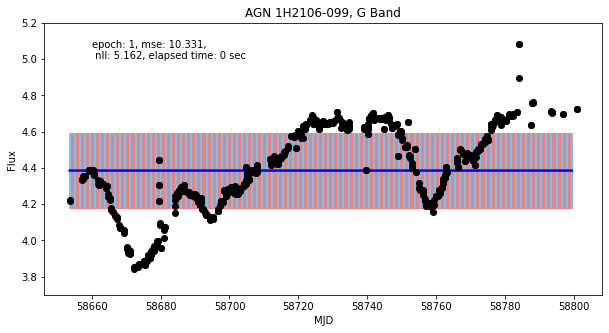

In [16]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
def animate(i):
    x = denorm_recons[i][:,0]
    y = denorm_recons[i][:,1]
    yerr = denorm_recons[i][:,2]

    ax.clear()
    w=2.0
    ax.fill_between(x, y - yerr, y+yerr, color='lightcoral', zorder=30)
    ax.plot(x, y, c='b', lw=w, label='Reconstructions', zorder=40)
    ax.scatter(ex[:,0], ex[:,1], c='black', zorder=50)
    ax.errorbar(x, y ,yerr=yerr,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions', zorder=40)
    ax.text(58660, 5, f'epoch: {epochs[i]}, mse: {mses[i]}, \n nll: {nlls[i]}, elapsed time: {elapsed[i]} sec', fontsize=10)
    #ax.set_xlim([58670,58700])
    ax.set_ylim([3.7,5.2])
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')
    ax.set_title('AGN 1H2106-099, G Band')
    

ani = FuncAnimation(fig, animate, frames=100, interval=100, repeat=False)

In [17]:
ani

In [16]:
# visualisation for one light curve w/ increasing number of points
def viz_per_example(example, target_x, net, num_points=40, device="mps", k_iwae=10, frac=0.5): 
    example = example[np.newaxis, :,:]
    target_x = target_x[np.newaxis, :, np.newaxis]
    np.random.seed(0)
    with torch.no_grad(): 
        # if torch.is_tensor(example):
        #     example = example.cpu().numpy()
        example = torch.tensor(example)
        # make new masks relative to fraction of points we got to predict w/ 
        subsampled_mask, recon_mask = my_utils.make_masks(example, frac=frac)
        #example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis], target_x), axis=-1) # format the masks 
        example = torch.cat((example, torch.unsqueeze(subsampled_mask, 2), torch.unsqueeze(recon_mask, 2), torch.tensor(target_x)), axis=-1)

        #example = torch.tensor(example)
        example = example.to(device)
        
        subsampled_mask = example[:,:,3:4]
        context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
        px, qz = net.get_reconstruction(example[:,:, 0], context_y, example[:,:,5], num_samples=k_iwae)

        qz_mean = (qz.mean.cpu().numpy())
        qz_std = (torch.exp(0.5 * qz.logvar).cpu().numpy())
        px_mean = px.mean.cpu().numpy()
        px_std = torch.exp(0.5 * px.logvar).cpu().numpy()
        example = example.cpu().numpy()

        px_mean = np.mean(px_mean, axis=0)[0,:num_points,0]
        px_std = np.mean(px_std, axis=0)[0,:num_points,0]
        target_x = target_x[0,:num_points,0]
        w=2.0
        #plt.figure(figsize=(30, 10))
        #plt.fill_between(target_x, px_mean - 2*px_std, px_mean+2*px_std, color='gray')

        # plt.plot(target_x, px_mean, c='b', lw=w, label='Reconstructions', zorder=20)
        # plt.scatter(example[0,:,0], example[0,:,1])
        # plt.errorbar(target_x, px_mean ,yerr=px_std,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')

        #plt.show()
        reconstruction = np.concatenate((target_x[:,np.newaxis], px_mean[:,np.newaxis], px_std[:,np.newaxis]), axis=1)
        #print(f'qz shape: {qz_mean.shape}')
        #print(f'reconstructed example: {reconstruction.shape}')
        return reconstruction, qz_mean,qz_std, example

